In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from anndata import AnnData

In [2]:
import jax.numpy as jnp

2023-01-04 14:33:26.900676: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 14:33:26.950065: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 14:33:26.952599: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
import cellrank as cr
import scvelo as scv

In [4]:
from moscot.problems.time import TemporalNeuralProblem

2023-01-04 14:33:28.898801: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-04 14:33:28.898833: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
path = "/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad"

In [6]:
adata = sc.read(path)

In [7]:
adata.obs["time"] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [8]:
marginals = pd.read_csv("marginals.csv", index_col="Unnamed: 0")
adata.obs["a"] = marginals

In [9]:
tnp = TemporalNeuralProblem(adata)

In [10]:
tnp = tnp.prepare("time", joint_attr="X_multi_vi", a="a")

In [11]:
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9811, 7107)].                            


  0%|          | 0/25000 [00:00<?, ?it/s]

In [12]:
tnp

TemporalNeuralProblem[(14.5, 15.5)]

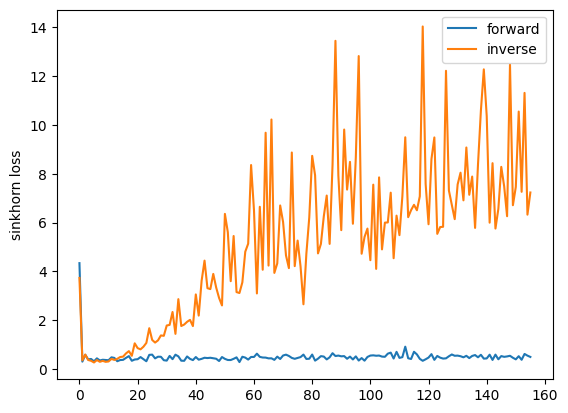

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

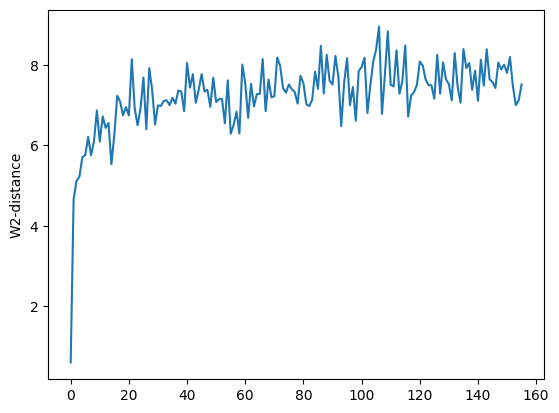

In [15]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

In [17]:
source = jnp.array(adata.obsm["X_multi_vi"].copy())

In [18]:
velocity = tnp[14.5, 15.5].solution.push(source) - source

In [19]:
adata_result = AnnData(shape=velocity.shape)
adata_result.obs = adata.obs.copy()

In [21]:
adata_result.layers["joint_velocity"] = np.asarray(velocity)
adata_result.layers["X_multi_vi"] = np.asarray(adata.obsm["X_multi_vi"])

In [22]:
adata_result

AnnData object with n_obs × n_vars = 16918 × 18
    obs: 'batch_id', 'modality', '_scvi_batch', 'celltype', 'sample', 'time', 'a'
    layers: 'joint_velocity', 'X_multi_vi'

In [23]:
adata_result.write("/lustre/groups/ml01/workspace/monge_velo/multiome_pancreas/adata_joint_velocities.h5ad")